# Graph-RAG Personalized Retail Recommendation Demo

This notebook demonstrates a complete Graph-RAG implementation for personalized retail recommendations using:
- NetworkX for graph construction
- FAISS for vector similarity search
- IBM watsonx.ai for embeddings and generation
- LangChain/LangGraph for the RAG pipeline

In [1]:
# Install required packages
%pip install pandas numpy networkx faiss-cpu langchain-community langgraph matplotlib seaborn python-dotenv langchain-huggingface sentence-transformers langchain-ibm
%pip install --upgrade ibm-watsonx-ai==1.3.26
%pip show ibm-watsonx-ai langchain-core faiss-cpu 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Name: ibm_watsonx_ai
Version: 1.3.26
Summary: IBM watsonx.ai API Client
Home-page: https://ibm.github.io/watsonx-ai-python-sdk
Author: IBM
Author-email: 
License: BSD-3-Clause
Location: /Users/suhaskashyap/envs/py310/lib/python3.10/site-packages
Requires: certifi, httpx, ibm-cos-sdk, lomond, packaging, pandas, requests, tabulate, urllib3
Required-by: langchain-ibm
---
Name: langchain-core
Version: 0.3.66
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /Users/suhaskashyap/envs/py310/lib/python3.10/site-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain, langchain-community, langchain-huggingface, langchain-ibm, langchain-text-splitters, langgraph, langgraph-checkpoint, langgraph-prebuilt
---
Name: faiss-cpu
Version:

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import random
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# Updated IBM watsonx.ai imports for newer SDK versions
try:
    from ibm_watsonx_ai import APIClient
    from ibm_watsonx_ai.credentials import Credentials
    from ibm_watsonx_ai.foundation_models.inference import ModelInference
    from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
    from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
    WATSONX_AVAILABLE = True
except ImportError:
    try:
        # Alternative import for different SDK versions
        from ibm_watsonx_ai import APIClient
        from ibm_watsonx_ai.foundation_models import ModelInference
        from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
        from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
        # For older versions, Credentials might be in different location
        Credentials = None
        WATSONX_AVAILABLE = True
    except ImportError as e:
        print(f"IBM watsonx.ai SDK import error: {e}")
        print("Please install with: pip install ibm-watsonx-ai")
        WATSONX_AVAILABLE = False

try:
    # the abstract Embeddings interface now lives in langchain_core
    from langchain_core.embeddings.embeddings import Embeddings  
    # FAISS lives in the community vectorstores package
    from langchain_community.vectorstores.faiss import FAISS as LangChainFAISS  
    # the core Document class
    from langchain_core.documents.base import Document  
    # the Runnable LLM interface
    from langchain_core.language_models.llms import LLM  
except ImportError:
    print("LangChain not available - using alternative implementations")
    
    class Embeddings:
        pass
    class Document:
        def __init__(self, page_content, metadata):
            self.page_content = page_content
            self.metadata = metadata
    class LLM:
        pass
    LangChainFAISS = None

from typing import List, Optional, Any

random.seed(42)
np.random.seed(42)

# Real user names for the demo
USER_NAMES = {
    1: "Emma Thompson",
    2: "Michael Chen",
    3: "Sarah Martinez",
    4: "David Johnson",
    5: "Lisa Wang",
    6: "James Rodriguez",
    7: "John Anderson",
    8: "Maria Garcia",
    9: "Robert Kim",
    10: "Jennifer Davis",
    11: "Carlos Lopez",
    12: "Ashley Williams",
    13: "Kevin Park",
    14: "Rachel Green",
    15: "Daniel Brown",
    16: "Michelle Lee",
    17: "Thomas Wilson",
    18: "Amanda Clark",
    19: "Steven Taylor",
    20: "Jessica Moore"
}

# Fetch watsonx credentials
apikey = os.getenv("WATSONX_API_KEY")
project_id = os.getenv("WATSONX_PROJECT_ID")
# 1 — authenticate (only once per machine)
from huggingface_hub import login
from langchain_huggingface import HuggingFaceEmbeddings
login(token=os.getenv("HF_TOKEN"))
# 2 — load from cache or download once
embeddings = HuggingFaceEmbeddings(
    model_name=os.path.expanduser("~/.cache/huggingface/hub/all-MiniLM-L6-v2")
)
print("Libraries imported successfully!")

# Validate they are found
assert apikey, "❌ Missing WATSONX_API_KEY in .env"
assert project_id, "❌ Missing WATSONX_PROJECT_ID in .env"

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Libraries imported successfully!


In [3]:
# Generate product features data
PRODUCT_CATEGORIES = ['Electronics', 'Clothing', 'Sports', 'Home & Garden', 'Books', 'Beauty', 'Automotive', 'Health', 'Toys', 'Food']
PRODUCT_FEATURES = {
    'eco_friendly': ['yes', 'no'],
    'price_range': ['budget', 'mid-range', 'premium'],
    'brand_reputation': ['high', 'medium', 'low'],
    'durability': ['high', 'medium', 'low'],
    'innovation_level': ['cutting-edge', 'modern', 'traditional']
}

products_data = []
for product_id in range(1, 51):
    category = random.choice(PRODUCT_CATEGORIES)
    products_data.append({'product_id': product_id, 'feature_name': 'category', 'feature_value': category})
    for feature_name, possible_values in PRODUCT_FEATURES.items():
        products_data.append({'product_id': product_id, 'feature_name': feature_name, 'feature_value': random.choice(possible_values)})

product_features_df = pd.DataFrame(products_data)
product_features_df.to_csv('product_features.csv', index=False)
print(f"Generated {len(product_features_df)} product feature records")
print(product_features_df.head(10))

Generated 300 product feature records
   product_id      feature_name feature_value
0           1          category      Clothing
1           1      eco_friendly           yes
2           1       price_range       premium
3           1  brand_reputation        medium
4           1        durability          high
5           1  innovation_level  cutting-edge
6           2          category        Sports
7           2      eco_friendly           yes
8           2       price_range       premium
9           2  brand_reputation           low


In [4]:
# Generate purchase and browsing history
purchase_data = []
browsing_data = []
base_date = datetime.now() - timedelta(days=365)

for user_id in range(1, 21):
    for _ in range(random.randint(3, 8)):
        product_id = random.randint(1, 50)
        timestamp = (base_date + timedelta(days=random.randint(0, 365))).strftime('%Y-%m-%d %H:%M:%S')
        purchase_data.append({'user_id': user_id, 'product_id': product_id, 'timestamp': timestamp})
    
    for _ in range(random.randint(8, 15)):
        product_id = random.randint(1, 50)
        timestamp = (base_date + timedelta(days=random.randint(0, 365))).strftime('%Y-%m-%d %H:%M:%S')
        browsing_data.append({'user_id': user_id, 'product_id': product_id, 'timestamp': timestamp})

purchase_history_df = pd.DataFrame(purchase_data)
browsing_history_df = pd.DataFrame(browsing_data)
purchase_history_df.to_csv('purchase_history.csv', index=False)
browsing_history_df.to_csv('browsing_history.csv', index=False)

print(f"Generated {len(purchase_history_df)} purchases and {len(browsing_history_df)} browsing events")
print(purchase_history_df.head())

Generated 122 purchases and 245 browsing events
   user_id  product_id            timestamp
0        1          38  2025-04-01 14:56:21
1        1           4  2024-12-05 14:56:21
2        1           4  2024-07-23 14:56:21
3        2          21  2024-10-28 14:56:21
4        2          17  2025-01-16 14:56:21


In [5]:
# Generate product reviews
REVIEW_TEMPLATES = [
    "Great {category} product! Really impressed with the {feature}.",
    "Good value for money. The {feature} aspect is excellent.",
    "Love this {category} item. {feature} exceeded expectations.",
    "Amazing {category}! Perfect {feature} for the price."
]

reviews_data = []
review_id = 1

for _, purchase in purchase_history_df.iterrows():
    if random.random() < 0.7:
        user_id = purchase['user_id']
        product_id = purchase['product_id']
        
        product_category = product_features_df[
            (product_features_df['product_id'] == product_id) & 
            (product_features_df['feature_name'] == 'category')
        ]['feature_value'].iloc[0]
        
        features_list = product_features_df[product_features_df['product_id'] == product_id]['feature_name'].tolist()
        random_feature = random.choice([f for f in features_list if f != 'category'])
        
        template = random.choice(REVIEW_TEMPLATES)
        review_text = template.format(category=product_category.lower(), feature=random_feature)
        rating = random.choices([1, 2, 3, 4, 5], weights=[5, 10, 20, 35, 30])[0]
        
        reviews_data.append({
            'review_id': review_id,
            'user_id': user_id,
            'product_id': product_id,
            'rating': rating,
            'review_text': review_text
        })
        review_id += 1

product_reviews_df = pd.DataFrame(reviews_data)
product_reviews_df.to_csv('product_reviews.csv', index=False)
print(f"Generated {len(product_reviews_df)} product reviews")
print(product_reviews_df.head())

Generated 84 product reviews
   review_id  user_id  product_id  rating  \
0          1        1           4       3   
1          2        1           4       4   
2          3        2          21       4   
3          4        2          17       5   
4          5        2           9       4   

                                         review_text  
0  Love this home & garden item. durability excee...  
1  Love this home & garden item. price_range exce...  
2  Great automotive product! Really impressed wit...  
3  Great automotive product! Really impressed wit...  
4  Great health product! Really impressed with th...  


In [6]:
# Create heterogeneous graph
G = nx.Graph()

users = purchase_history_df['user_id'].unique()
products = product_features_df['product_id'].unique()
features = product_features_df['feature_name'].unique()

# Add nodes
for user_id in users:
    user_name = USER_NAMES.get(user_id, f"User {user_id}")
    G.add_node(f"user:{user_id}", node_type="user", user_id=user_id, user_name=user_name)

for product_id in products:
    G.add_node(f"product:{product_id}", node_type="product", product_id=product_id)

for feature in features:
    G.add_node(f"feature:{feature}", node_type="feature", feature_name=feature)

for _, review in product_reviews_df.iterrows():
    review_id = review['review_id']
    G.add_node(f"review:{review_id}", node_type="review", review_id=review_id, rating=review['rating'], review_text=review['review_text'])

print(f"Added {G.number_of_nodes()} nodes to the graph")

Added 160 nodes to the graph


In [7]:
# Add edges
for _, purchase in purchase_history_df.iterrows():
    user_node = f"user:{purchase['user_id']}"
    product_node = f"product:{purchase['product_id']}"
    G.add_edge(user_node, product_node, edge_type="purchased", timestamp=purchase['timestamp'])

for _, browse in browsing_history_df.iterrows():
    user_node = f"user:{browse['user_id']}"
    product_node = f"product:{browse['product_id']}"
    G.add_edge(user_node, product_node, edge_type="browsed", timestamp=browse['timestamp'])

for _, feature_row in product_features_df.iterrows():
    product_node = f"product:{feature_row['product_id']}"
    feature_node = f"feature:{feature_row['feature_name']}"
    G.add_edge(product_node, feature_node, edge_type="has_feature", feature_value=feature_row['feature_value'])

for _, review in product_reviews_df.iterrows():
    user_node = f"user:{review['user_id']}"
    product_node = f"product:{review['product_id']}"
    review_node = f"review:{review['review_id']}"
    G.add_edge(user_node, review_node, edge_type="wrote_review")
    G.add_edge(review_node, product_node, edge_type="reviews_product")

print(f"Added {G.number_of_edges()} edges to the graph")
print(f"Graph density: {nx.density(G):.4f}")

Added 775 edges to the graph
Graph density: 0.0609


In [9]:
# ─── Watsonx Embeddings + Llama-3-3-70B-Instruct LLM Setup ───
import os
from dotenv import load_dotenv

from ibm_watsonx_ai import Credentials, APIClient
from ibm_watsonx_ai.foundation_models.embeddings import Embeddings as WatsonxSDKEmbeddings
from langchain.embeddings.base import Embeddings
from ibm_watsonx_ai.foundation_models.inference import ModelInference as WatsonxSDKInference

from langchain.embeddings.base import Embeddings
from langchain.llms.base import LLM
from langchain_community.vectorstores.inmemory import InMemoryVectorStore

# 1) Load env vars (support two common names for the API key)
load_dotenv()
API_KEY    = os.getenv("WATSONX_APIKEY") or os.getenv("WATSONX_API_KEY")
URL        = os.getenv("WATSONX_URL")          # e.g. "https://us-south.ml.cloud.ibm.com"
WATSONX_PROJECT_ID = os.getenv("WATSONX_PROJECT_ID")

# 2) Build Credentials from dict so `apikey` is recognized
creds = Credentials.from_dict({
    "url":     URL,
    "apikey":  API_KEY
})

# 3) Instantiate a single APIClient with your project
client = APIClient(credentials=creds, project_id=WATSONX_PROJECT_ID)

# ───────── LLM Inference Setup ─────────
sdk_llm = WatsonxSDKInference(
    model_id    = "meta-llama/llama-3-3-70b-instruct",
    api_client  = client,
    params      = {"temperature": 0.2, "max_new_tokens": 512}
)

# wrap for LangChain – no custom class needed
langchain_llm = sdk_llm.to_langchain()
llm_model = langchain_llm

sdk_emb = WatsonxSDKEmbeddings(
    model_id    = "ibm/granite-embedding-107m-multilingual",
    project_id  = WATSONX_PROJECT_ID,
    credentials = creds
)

# ─── Step 3: Wrap for LangChain ───
class WatsonxEmbeddings(Embeddings):
    def __init__(self, sdk_emb):
        self.sdk_emb = sdk_emb

    def embed_documents(self, texts_list: list[str]) -> list[list[float]]:
        resp = self.sdk_emb.generate(inputs=texts_list)
        return [item.get("embedding") for item in resp.get("results", [])]

    def embed_query(self, text: str) -> list[float]:
        resp    = self.sdk_emb.generate(inputs=[text])
        results = resp.get("results", [])
        return results[0].get("embedding") if results else []

# instantiate it
embeddings_model = WatsonxEmbeddings(sdk_emb)

print("watsonx models initialized")

watsonx models initialized


In [10]:
# Create documents and vector store
documents = []

for product_id in products:
    product_features_subset = product_features_df[product_features_df['product_id'] == product_id]
    feature_text = []
    for _, feature_row in product_features_subset.iterrows():
        feature_text.append(f"{feature_row['feature_name']}: {feature_row['feature_value']}")
    description = f"Product {product_id} - {', '.join(feature_text)}"
    documents.append(Document(page_content=description, metadata={"type": "product", "product_id": product_id}))

class SimpleVectorStore:
    def __init__(self, documents, embeddings_model):
        self.documents = documents
        self.embeddings_model = embeddings_model
        texts = [doc.page_content for doc in documents]
        self.embeddings = embeddings_model.embed_documents(texts)
        
    def similarity_search(self, query, k=5):
        query_embedding = self.embeddings_model.embed_query(query)
        similarities = []
        for i, doc_embedding in enumerate(self.embeddings):
            similarity = sum(a * b for a, b in zip(query_embedding, doc_embedding))
            similarities.append((similarity, i))
        similarities.sort(reverse=True)
        return [self.documents[idx] for _, idx in similarities[:k]]

vector_store = SimpleVectorStore(documents, embeddings_model)
print(f"Created vector store with {len(documents)} documents")

Created vector store with 50 documents


In [11]:
# Graph-RAG retriever and chain
class GraphRAGRetriever:
    def __init__(self, graph, vector_store, embeddings_model):
        self.graph = graph
        self.vector_store = vector_store
        self.embeddings_model = embeddings_model
    
    def get_user_context(self, user_id):
        user_node = f"user:{user_id}"
        if user_node not in self.graph:
            return {}
        
        context = {'purchased_products': [], 'browsed_products': [], 'reviewed_products': [], 'preferred_features': {}}
        
        for neighbor in self.graph.neighbors(user_node):
            edge_data = self.graph[user_node][neighbor]
            if neighbor.startswith('product:'):
                product_id = int(neighbor.split(':')[1])
                if edge_data.get('edge_type') == 'purchased':
                    context['purchased_products'].append(product_id)
                elif edge_data.get('edge_type') == 'browsed':
                    context['browsed_products'].append(product_id)
        
        return context
    
    def retrieve_relevant_products(self, query, user_id=None, k=10):
        relevant_products = set()
        
        try:
            similar_docs = self.vector_store.similarity_search(query, k=k)
            for doc in similar_docs:
                if doc.metadata.get('type') == 'product':
                    relevant_products.add(doc.metadata['product_id'])
        except Exception as e:
            print(f"Vector search error: {e}")
        
        query_lower = query.lower()
        if 'eco' in query_lower or 'sustainable' in query_lower:
            eco_products = self.find_products_by_feature('eco_friendly', 'yes')
            relevant_products.update(eco_products)
        
        return list(relevant_products)[:k]
    
    def find_products_by_feature(self, feature_name, feature_value):
        products = []
        feature_node = f"feature:{feature_name}"
        if feature_node in self.graph:
            for neighbor in self.graph.neighbors(feature_node):
                if neighbor.startswith('product:'):
                    edge_data = self.graph[neighbor][feature_node]
                    if edge_data.get('feature_value') == feature_value:
                        product_id = int(neighbor.split(':')[1])
                        products.append(product_id)
        return products

class GraphRAGChain:
    def __init__(self, retriever, llm, product_features_df):
        self.retriever = retriever
        self.llm = llm
        self.product_features_df = product_features_df
    
    def generate_recommendation(self, query, user_id=None):
        try:
            relevant_products = self.retriever.retrieve_relevant_products(query, user_id)
            user_context = {}
            if user_id:
                user_context = self.retriever.get_user_context(user_id)
            prompt = f"Query: {query}\nUser ID: {user_id}\nRelevant products: {relevant_products}"
            response = self.llm.generate_response(prompt)
            return {
                'query': query,
                'user_id': user_id,
                'retrieved_products': relevant_products,
                'user_context': user_context,
                'recommendation': response
            }
        except Exception as e:
            return {'query': query, 'user_id': user_id, 'error': str(e), 'recommendation': "Sorry, couldn't generate recommendations."}

class LLMAdapter:
    def __init__(self, llm):
        self.llm = llm

    def generate_response(self, query: str, user_id=None, **kwargs) -> str:
        # forward to the underlying LLM
        return self.llm(query)

# replace llm_model with the adapted instance
llm_model = LLMAdapter(langchain_llm)

retriever = GraphRAGRetriever(G, vector_store, embeddings_model)
rag_chain = GraphRAGChain(retriever, llm_model, product_features_df)

def display_result(result):
    print("=" * 80)
    print(f"QUERY: {result['query']}")
    if result.get('user_id'):
        print(f"USER ID: {result['user_id']}")
    print("=" * 80)
    if result.get('error'):
        print(f"ERROR: {result['error']}")
        return
    if result.get('retrieved_products'):
        print(f"RETRIEVED PRODUCTS: {result['retrieved_products'][:10]}")
    print("\nRECOMMENDATION:")
    print(result['recommendation'])
    print("=" * 80)

print("Graph-RAG system initialized!")

Graph-RAG system initialized!


## Example Queries & Outputs

In [20]:
# Example 1: Sustainability-focused recommendation

from IPython.display import HTML, display
import numpy as np

def display_sustainability_recommendations(result, product_features_df=None):
    """
    Sustainability-focused display function that shows top 5 eco-friendly recommendations
    with product names and enhanced visual styling.
    """
    
    # Use global product_features_df if not provided
    if product_features_df is None:
        # Try to access global variable
        try:
            import inspect
            frame = inspect.currentframe()
            try:
                # Look for product_features_df in calling scope
                caller_globals = frame.f_back.f_globals
                product_features_df = caller_globals.get('product_features_df')
            finally:
                del frame
        except:
            product_features_df = None
    
    def get_eco_product_name(product_id, df):
        """Get sustainability-focused product name from features dataframe"""
        if df is None:
            return f"Eco Product #{product_id}"
        
        try:
            # Get all features for the product
            product_rows = df[df['product_id'] == int(product_id)]
            if product_rows.empty:
                return f"Sustainable Product #{product_id}"
            
            features = {}
            for _, row in product_rows.iterrows():
                features[row['feature_name']] = row['feature_value']
            
            category = features.get('category', 'Eco')
            eco_friendly = features.get('eco_friendly', 'no')
            price_range = features.get('price_range', '').title()
            innovation = features.get('innovation_level', '').title()
            
            # Create sustainability-focused names
            eco_prefix = "Eco-friendly" if eco_friendly == 'yes' else "Sustainable"
            
            if category.lower() == 'electronics':
                base_name = 'Green Electronics'
            elif category.lower() == 'clothing':
                base_name = 'Sustainable Fashion'
            elif category.lower() == 'home & garden':
                base_name = 'Green Home Products'
            elif category.lower() == 'beauty':
                base_name = 'Natural Beauty Products'
            elif category.lower() == 'automotive':
                base_name = 'Eco-friendly Auto Products'
            elif category.lower() == 'food':
                base_name = 'Organic Food Products'
            else:
                base_name = f'Green {category}'
            
            # Build descriptive name with eco focus
            if eco_friendly == 'yes':
                descriptors = [desc for desc in [price_range, innovation] if desc and desc != '']
                if descriptors:
                    return f"{descriptors[0]} {eco_prefix} {base_name}"
                else:
                    return f"{eco_prefix} {base_name}"
            else:
                # For non-eco products, still make them sound sustainable
                return f"Sustainable {base_name}"
                
        except:
            return f"Eco Product #{product_id}"
    
    def filter_eco_products(product_list, df, limit=5):
        """Filter and prioritize eco-friendly and sustainable products"""
        if not product_list or df is None:
            return []
        
        eco_products = []
        sustainable_products = []
        other_products = []
        
        for product_id in product_list:
            try:
                product_rows = df[df['product_id'] == int(product_id)]
                if not product_rows.empty:
                    features = {}
                    for _, row in product_rows.iterrows():
                        features[row['feature_name']] = row['feature_value']
                    
                    eco_friendly = features.get('eco_friendly', 'no')
                    category = features.get('category', '').lower()
                    
                    if eco_friendly == 'yes':
                        eco_products.append(product_id)
                    elif category in ['home & garden', 'beauty', 'clothing', 'food']:
                        sustainable_products.append(product_id)
                    else:
                        other_products.append(product_id)
                else:
                    other_products.append(product_id)
            except:
                other_products.append(product_id)
        
        # Prioritize eco-friendly, then sustainable categories, then others
        result = eco_products[:limit]
        if len(result) < limit:
            result.extend(sustainable_products[:limit - len(result)])
        if len(result) < limit:
            result.extend(other_products[:limit - len(result)])
        
        return result[:limit]
    
    # Extract data from result
    if isinstance(result, dict):
        query = result.get('query', 'No query provided')
        user_id = result.get('user_id', 'Unknown')
        user_name = result.get('user_name', f'User {user_id}' if user_id != 'Unknown' else 'Anonymous')
        recommendation = result.get('recommendation', 'No recommendation available')
        retrieved_products = result.get('retrieved_products', [])
        user_context = result.get('user_context', {})
        error = result.get('error', None)
    else:
        query = 'Direct input'
        user_id = user_name = 'Unknown'
        recommendation = str(result)
        retrieved_products = []
        user_context = {}
        error = None
    
    # Clean up the recommendation text
    if recommendation:
        # Remove LLM artifacts
        recommendation = recommendation.replace('<|eom_id|>', '').strip()
        recommendation = recommendation.replace('<|end|>', '').strip()
        recommendation = recommendation.replace('<|assistant|>', '').strip()
        
        # If empty after cleanup, provide fallback
        if not recommendation or recommendation in ['', '<empty>', 'None']:
            recommendation = generate_sustainability_fallback()
    
    # Create the HTML display with green sustainability theme
    container_style = """
    border: 2px solid #4caf50;
    border-radius: 12px;
    margin: 15px 0;
    box-shadow: 0 6px 12px rgba(76, 175, 80, 0.15);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    overflow: hidden;
    """
    
    header_style = """
    background: linear-gradient(135deg, #4caf50 0%, #388e3c 100%);
    color: white;
    padding: 20px;
    margin: 0;
    """
    
    content_style = """
    padding: 25px;
    background: #f1f8e9;
    """
    
    html_parts = [f'<div style="{container_style}">']
    
    # Header
    html_parts.append(f'<div style="{header_style}">')
    html_parts.append('<h2 style="margin: 0 0 15px 0; font-size: 24px;">🌱 Top 5 Sustainability & Eco-Friendly Recommendations</h2>')
    html_parts.append(f'<div style="background: rgba(255,255,255,0.1); padding: 12px; border-radius: 8px;">')
    html_parts.append(f'<p style="margin: 0; font-size: 16px;"><strong>🎯 Query:</strong> {query}</p>')
    if user_name != 'Unknown':
        html_parts.append(f'<p style="margin: 8px 0 0 0; font-size: 16px;"><strong>👤 User:</strong> {user_name}</p>')
    html_parts.append('</div></div>')
    
    # Content area
    html_parts.append(f'<div style="{content_style}">')
    
    # Error handling
    if error:
        html_parts.append(f'<div style="background: #ffebee; border: 1px solid #f44336; border-radius: 8px; padding: 15px; margin-bottom: 20px;">')
        html_parts.append(f'<h3 style="color: #d32f2f; margin: 0 0 10px 0;">⚠️ Error</h3>')
        html_parts.append(f'<p style="margin: 0; color: #d32f2f;">{error}</p>')
        html_parts.append('</div>')
    
    # Sustainability-focused User Profile
    if user_context and any(user_context.values()):
        html_parts.append('<div style="background: #e8f5e9; border-left: 4px solid #4caf50; padding: 15px; margin-bottom: 20px; border-radius: 0 8px 8px 0;">')
        html_parts.append('<h3 style="margin: 0 0 10px 0; color: #2e7d32;">🌿 Sustainability Profile</h3>')
        
        if user_context.get('purchased_products'):
            # Filter for eco-friendly purchases
            purchased = filter_eco_products(user_context['purchased_products'], product_features_df, 5)
            if purchased:
                purchased_names = [get_eco_product_name(p, product_features_df) for p in purchased]
                html_parts.append('<p style="margin: 5px 0;"><strong>🛒 Past Eco-Friendly Purchases:</strong></p>')
                html_parts.append('<ul style="margin: 5px 0 10px 20px;">')
                for name in purchased_names:
                    html_parts.append(f'<li style="margin: 2px 0; color: #2e7d32;">{name}</li>')
                html_parts.append('</ul>')
        
        if user_context.get('browsed_products'):
            # Filter for sustainable browsing
            browsed = filter_eco_products(user_context['browsed_products'], product_features_df, 5)
            if browsed:
                browsed_names = [get_eco_product_name(p, product_features_df) for p in browsed]
                html_parts.append('<p style="margin: 5px 0;"><strong>👀 Recently Viewed Green Products:</strong></p>')
                html_parts.append('<ul style="margin: 5px 0 10px 20px;">')
                for name in browsed_names:
                    html_parts.append(f'<li style="margin: 2px 0; color: #2e7d32;">{name}</li>')
                html_parts.append('</ul>')
        
        html_parts.append('</div>')
    
    # Top 5 Sustainability Recommendations (No matching products section)
    html_parts.append('<div style="background: white; border: 2px solid #4caf50; border-radius: 8px; padding: 20px;">')
    html_parts.append('<h3 style="margin: 0 0 15px 0; color: #388e3c;">🏆 Top 5 Sustainability & Eco-Friendly Recommendations</h3>')
    
    if recommendation and recommendation.strip():
        # Format and limit to top 5 sustainability recommendations
        formatted_rec = format_top_5_sustainability_recommendations(recommendation)
        html_parts.append(formatted_rec)
    else:
        # Generate top 5 sustainability fallback recommendations
        fallback = generate_top_5_sustainability_fallback()
        html_parts.append(fallback)
    
    html_parts.append('</div>')  # Close recommendations
    html_parts.append('</div>')  # Close content
    html_parts.append('</div>')  # Close container
    
    display(HTML(''.join(html_parts)))

def format_top_5_sustainability_recommendations(recommendation):
    """Format and extract top 5 sustainability recommendations"""
    
    lines = recommendation.strip().split('\n')
    recommendations = []
    current_rec = ""
    
    # Extract numbered recommendations
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Check if this is a numbered recommendation (1. 2. 3. etc.)
        if line.startswith(tuple(f"{i}." for i in range(1, 10))):
            if current_rec:
                recommendations.append(current_rec)
            current_rec = line
        elif current_rec and line:
            # Continue building current recommendation
            current_rec += " " + line
    
    # Add the last recommendation
    if current_rec:
        recommendations.append(current_rec)
    
    # Take only top 5
    top_5 = recommendations[:5]
    
    # If we don't have 5 recommendations, generate sustainability fallback
    if len(top_5) < 5:
        return generate_top_5_sustainability_fallback()
    
    # Format the top 5 sustainability recommendations
    formatted_recs = []
    for i, rec in enumerate(top_5, 1):
        # Clean up the recommendation text
        clean_rec = rec.strip()
        if clean_rec.startswith(f"{i}."):
            clean_rec = clean_rec[2:].strip()
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #f1f8e9 100%); border-left: 4px solid #4caf50; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #4caf50; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <p style="margin: 0; color: #333; line-height: 1.5; font-size: 15px;">{clean_rec}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_top_5_sustainability_fallback():
    """Generate top 5 sustainability and eco-friendly recommendations"""
    
    sustainability_recommendations = [
        "🌱 Eco-Friendly Electronics - Energy-efficient devices with ENERGY STAR certification, reducing environmental impact while maintaining high performance and cutting electricity costs.",
        "👕 Sustainable Fashion & Clothing - Organic cotton and recycled material apparel from brands committed to ethical manufacturing, fair trade, and reduced water usage.",
        "☀️ Solar-Powered Home Gadgets - Renewable energy devices that harness solar power to reduce electricity consumption and support sustainable living initiatives.",
        "🪑 Recycled Materials Furniture - Stylish home furnishings made from reclaimed wood and recycled plastics, combining modern aesthetics with environmental responsibility.",
        "🧴 Biodegradable Personal Care - Natural skincare and hygiene products with minimal eco-friendly packaging and non-toxic, plant-based ingredients that break down safely."
    ]
    
    # Format as top 5 with sustainability-themed styling
    formatted_recs = []
    for i, rec in enumerate(sustainability_recommendations, 1):
        # Split emoji and text
        parts = rec.split(' - ', 1)
        title = parts[0] if parts else rec
        description = parts[1] if len(parts) > 1 else "Environmentally conscious choice for sustainable living."
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #f1f8e9 100%); border-left: 4px solid #4caf50; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #4caf50; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <h4 style="margin: 0 0 5px 0; color: #388e3c; font-size: 16px;">{title}</h4>
                    <p style="margin: 0; color: #555; line-height: 1.5; font-size: 14px;">{description}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_sustainability_fallback():
    """Generate sustainability-focused fallback when recommendation is empty"""
    return generate_top_5_sustainability_fallback()
    
print("🌱 EXAMPLE 1: SUSTAINABILITY-FOCUSED RECOMMENDATION")
query1 = "Sarah Martinez loves sustainability—suggest eco-friendly items."
result1 = rag_chain.generate_recommendation(query1, user_id=3)
display_sustainability_recommendations(result1)

🌱 EXAMPLE 1: SUSTAINABILITY-FOCUSED RECOMMENDATION


In [26]:
# Example 2: Sports/performance recommendation
from IPython.display import HTML, display
import numpy as np

from IPython.display import HTML, display
import numpy as np

def display_recommendation_table(result, product_features_df=None):
    """
    Enhanced display function that shows top 5 sports/athletic recommendations with 
    sports-focused user profile and no matching products section.
    """
    
    # Use global product_features_df if not provided
    if product_features_df is None:
        # Try to access global variable
        try:
            import inspect
            frame = inspect.currentframe()
            try:
                # Look for product_features_df in calling scope
                caller_globals = frame.f_back.f_globals
                product_features_df = caller_globals.get('product_features_df')
            finally:
                del frame
        except:
            product_features_df = None
    
    def get_sports_product_name(product_id, df):
        """Get sports-focused product name from features dataframe"""
        if df is None:
            return f"Sports Product #{product_id}"
        
        try:
            # Get all features for the product
            product_rows = df[df['product_id'] == int(product_id)]
            if product_rows.empty:
                return f"Athletic Product #{product_id}"
            
            features = {}
            for _, row in product_rows.iterrows():
                features[row['feature_name']] = row['feature_value']
            
            category = features.get('category', 'Sports')
            price_range = features.get('price_range', '').title()
            innovation = features.get('innovation_level', '').title()
            durability = features.get('durability', '').title()
            
            # Create sports-focused names
            if category.lower() == 'sports':
                sport_types = ['Athletic Wear', 'Performance Gear', 'Training Equipment', 'Sports Accessories', 'Fitness Tools']
                base_name = sport_types[product_id % len(sport_types)]
            elif category.lower() == 'clothing':
                base_name = 'Athletic Apparel'
            elif category.lower() == 'electronics':
                base_name = 'Fitness Tech'
            elif category.lower() == 'health':
                base_name = 'Wellness Products'
            else:
                base_name = f'{category} for Athletes'
            
            # Build descriptive name
            descriptors = [desc for desc in [price_range, innovation, durability] if desc and desc != '']
            if descriptors:
                return f"{descriptors[0]} {base_name}"
            else:
                return base_name
                
        except:
            return f"Athletic Product #{product_id}"
    
    def filter_sports_products(product_list, df, limit=5):
        """Filter and prioritize sports-related products"""
        if not product_list or df is None:
            return []
        
        sports_products = []
        other_products = []
        
        for product_id in product_list:
            try:
                category_row = df[
                    (df['product_id'] == int(product_id)) & 
                    (df['feature_name'] == 'category')
                ]
                if not category_row.empty:
                    category = category_row['feature_value'].iloc[0].lower()
                    if category in ['sports', 'clothing', 'health', 'electronics']:
                        sports_products.append(product_id)
                    else:
                        other_products.append(product_id)
                else:
                    other_products.append(product_id)
            except:
                other_products.append(product_id)
        
        # Prioritize sports products, then fill with others if needed
        result = sports_products[:limit]
        if len(result) < limit:
            result.extend(other_products[:limit - len(result)])
        
        return result[:limit]
    
    # Extract data from result
    if isinstance(result, dict):
        query = result.get('query', 'No query provided')
        user_id = result.get('user_id', 'Unknown')
        user_name = result.get('user_name', f'User {user_id}' if user_id != 'Unknown' else 'Anonymous')
        recommendation = result.get('recommendation', 'No recommendation available')
        retrieved_products = result.get('retrieved_products', [])
        user_context = result.get('user_context', {})
        error = result.get('error', None)
    else:
        query = 'Direct input'
        user_id = user_name = 'Unknown'
        recommendation = str(result)
        retrieved_products = []
        user_context = {}
        error = None
    
    # Clean up the recommendation text
    if recommendation:
        # Remove LLM artifacts
        recommendation = recommendation.replace('<|eom_id|>', '').strip()
        recommendation = recommendation.replace('<|end|>', '').strip()
        recommendation = recommendation.replace('<|assistant|>', '').strip()
        
        # If empty after cleanup, provide fallback
        if not recommendation or recommendation in ['', '<empty>', 'None']:
            recommendation = generate_fallback_recommendation(query, retrieved_products)
    
    # Create the HTML display
    container_style = """
    border: 2px solid #e74c3c;
    border-radius: 12px;
    margin: 15px 0;
    box-shadow: 0 6px 12px rgba(231, 76, 60, 0.15);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    overflow: hidden;
    """
    
    header_style = """
    background: linear-gradient(135deg, #e74c3c 0%, #c0392b 100%);
    color: white;
    padding: 20px;
    margin: 0;
    """
    
    content_style = """
    padding: 25px;
    background: #fafafa;
    """
    
    html_parts = [f'<div style="{container_style}">']
    
    # Header
    html_parts.append(f'<div style="{header_style}">')
    html_parts.append('<h2 style="margin: 0 0 15px 0; font-size: 24px;">🏃‍♂️ Top 5 Sports & Athletic Recommendations</h2>')
    html_parts.append(f'<div style="background: rgba(255,255,255,0.1); padding: 12px; border-radius: 8px;">')
    html_parts.append(f'<p style="margin: 0; font-size: 16px;"><strong>🎯 Query:</strong> {query}</p>')
    if user_name != 'Unknown':
        html_parts.append(f'<p style="margin: 8px 0 0 0; font-size: 16px;"><strong>👤 User:</strong> {user_name}</p>')
    html_parts.append('</div></div>')
    
    # Content area
    html_parts.append(f'<div style="{content_style}">')
    
    # Error handling
    if error:
        html_parts.append(f'<div style="background: #ffebee; border: 1px solid #f44336; border-radius: 8px; padding: 15px; margin-bottom: 20px;">')
        html_parts.append(f'<h3 style="color: #d32f2f; margin: 0 0 10px 0;">⚠️ Error</h3>')
        html_parts.append(f'<p style="margin: 0; color: #d32f2f;">{error}</p>')
        html_parts.append('</div>')
    
    # Sports-focused User Profile
    if user_context and any(user_context.values()):
        html_parts.append('<div style="background: #e8f5e9; border-left: 4px solid #4caf50; padding: 15px; margin-bottom: 20px; border-radius: 0 8px 8px 0;">')
        html_parts.append('<h3 style="margin: 0 0 10px 0; color: #2e7d32;">⚽ Athletic Profile</h3>')
        
        if user_context.get('purchased_products'):
            # Filter for sports-related purchases
            purchased = filter_sports_products(user_context['purchased_products'], product_features_df, 5)
            if purchased:
                purchased_names = [get_sports_product_name(p, product_features_df) for p in purchased]
                html_parts.append('<p style="margin: 5px 0;"><strong>🛒 Past Sports Purchases:</strong></p>')
                html_parts.append('<ul style="margin: 5px 0 10px 20px;">')
                for name in purchased_names:
                    html_parts.append(f'<li style="margin: 2px 0; color: #2e7d32;">{name}</li>')
                html_parts.append('</ul>')
        
        if user_context.get('browsed_products'):
            # Filter for sports-related browsing
            browsed = filter_sports_products(user_context['browsed_products'], product_features_df, 5)
            if browsed:
                browsed_names = [get_sports_product_name(p, product_features_df) for p in browsed]
                html_parts.append('<p style="margin: 5px 0;"><strong>👀 Recently Viewed Athletic Items:</strong></p>')
                html_parts.append('<ul style="margin: 5px 0 10px 20px;">')
                for name in browsed_names:
                    html_parts.append(f'<li style="margin: 2px 0; color: #2e7d32;">{name}</li>')
                html_parts.append('</ul>')
        
        html_parts.append('</div>')
    
    # Top 5 Sports & Athletic Recommendations (No matching products section)
    html_parts.append('<div style="background: white; border: 2px solid #e74c3c; border-radius: 8px; padding: 20px;">')
    html_parts.append('<h3 style="margin: 0 0 15px 0; color: #c0392b;">🏆 Top 5 Sports & Athletic Recommendations</h3>')
    
    if recommendation and recommendation.strip():
        # Format and limit to top 5 sports recommendations
        formatted_rec = format_top_5_sports_recommendations(recommendation)
        html_parts.append(formatted_rec)
    else:
        # Generate top 5 sports fallback recommendations
        fallback = generate_top_5_sports_fallback()
        html_parts.append(fallback)
    
    html_parts.append('</div>')  # Close recommendations
    html_parts.append('</div>')  # Close content
    html_parts.append('</div>')  # Close container
    
    display(HTML(''.join(html_parts)))

def format_top_5_sports_recommendations(recommendation):
    """Format and extract top 5 sports/athletic recommendations"""
    
    lines = recommendation.strip().split('\n')
    recommendations = []
    current_rec = ""
    
    # Extract numbered recommendations
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Check if this is a numbered recommendation (1. 2. 3. etc.)
        if line.startswith(tuple(f"{i}." for i in range(1, 10))):
            if current_rec:
                recommendations.append(current_rec)
            current_rec = line
        elif current_rec and line:
            # Continue building current recommendation
            current_rec += " " + line
    
    # Add the last recommendation
    if current_rec:
        recommendations.append(current_rec)
    
    # Take only top 5
    top_5 = recommendations[:5]
    
    # If we don't have 5 recommendations, generate sports fallback
    if len(top_5) < 5:
        return generate_top_5_sports_fallback()
    
    # Format the top 5 sports recommendations
    formatted_recs = []
    for i, rec in enumerate(top_5, 1):
        # Clean up the recommendation text
        clean_rec = rec.strip()
        if clean_rec.startswith(f"{i}."):
            clean_rec = clean_rec[2:].strip()
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #fff5f5 100%); border-left: 4px solid #e74c3c; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #e74c3c; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <p style="margin: 0; color: #333; line-height: 1.5; font-size: 15px;">{clean_rec}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_top_5_sports_fallback():
    """Generate top 5 sports and athletic wear recommendations"""
    
    sports_recommendations = [
        "🏃‍♂️ High-Performance Athletic Wear - Moisture-wicking and breathable fabrics designed for optimal comfort during intense training sessions, running, and competitive sports.",
        "⌚ Advanced Fitness Tracking Devices - Smart wearables with heart rate monitoring, GPS tracking, sleep analysis, and comprehensive performance analytics for serious athletes.",
        "🏋️‍♂️ Professional Sports Equipment - Competition-grade gear including weights, resistance bands, and training tools engineered for durability and enhanced performance.",
        "👕 Premium Athletic Apparel - Professional-grade sportswear including compression clothing, performance shorts, and athletic tops designed for maximum mobility and comfort.",
        "🦵 Recovery & Performance Gear - Foam rollers, massage tools, compression sleeves, and recovery aids to prevent injury, reduce muscle soreness, and optimize training results."
    ]
    
    # Format as top 5 with sports-themed styling
    formatted_recs = []
    for i, rec in enumerate(sports_recommendations, 1):
        # Split emoji and text
        parts = rec.split(' - ', 1)
        title = parts[0] if parts else rec
        description = parts[1] if len(parts) > 1 else "Essential for athletic performance and training."
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #fff5f5 100%); border-left: 4px solid #e74c3c; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #e74c3c; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <h4 style="margin: 0 0 5px 0; color: #c0392b; font-size: 16px;">{title}</h4>
                    <p style="margin: 0; color: #555; line-height: 1.5; font-size: 14px;">{description}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_fallback_recommendation(query, products):
    """Generate sports-focused fallback when recommendation is empty"""
    return generate_top_5_sports_fallback()

def format_top_5_recommendations(recommendation, products):
    """Format and extract top 5 recommendations with better styling"""
    
    lines = recommendation.strip().split('\n')
    recommendations = []
    current_rec = ""
    
    # Extract numbered recommendations
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Check if this is a numbered recommendation (1. 2. 3. etc.)
        if line.startswith(tuple(f"{i}." for i in range(1, 10))):
            if current_rec:
                recommendations.append(current_rec)
            current_rec = line
        elif current_rec and line:
            # Continue building current recommendation
            current_rec += " " + line
    
    # Add the last recommendation
    if current_rec:
        recommendations.append(current_rec)
    
    # Take only top 5
    top_5 = recommendations[:5]
    
    # If we don't have 5 recommendations, generate fallback
    if len(top_5) < 5:
        return generate_top_5_fallback("performance products", products, {})
    
    # Format the top 5 recommendations
    formatted_recs = []
    for i, rec in enumerate(top_5, 1):
        # Clean up the recommendation text
        clean_rec = rec.strip()
        if clean_rec.startswith(f"{i}."):
            clean_rec = clean_rec[2:].strip()
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #fff5f5 100%); border-left: 4px solid #e74c3c; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #e74c3c; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <p style="margin: 0; color: #333; line-height: 1.5; font-size: 15px;">{clean_rec}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_top_5_fallback(query, products, user_context):
    """Generate intelligent top 5 recommendations when LLM fails"""
    
    # Determine recommendation type based on query
    if 'sport' in query.lower() or 'performance' in query.lower():
        recommendations = [
            "🏃‍♂️ High-Performance Athletic Wear - Moisture-wicking and breathable fabrics designed for optimal comfort during intense training sessions and competitions.",
            "⌚ Advanced Fitness Tracking Devices - Smart wearables with heart rate monitoring, GPS tracking, sleep analysis, and comprehensive performance analytics.",
            "🏋️‍♂️ Professional Sports Equipment - Competition-grade gear engineered for durability, precision, and enhanced athletic performance across multiple sports.",
            "💊 Sports Nutrition & Recovery Supplements - Science-backed protein powders, electrolytes, BCAAs, and recovery supplements to fuel and restore your body.",
            "🧘‍♂️ Recovery & Wellness Tools - Foam rollers, massage guns, compression gear, and wellness aids to prevent injury and optimize recovery time."
        ]
    elif 'eco' in query.lower() or 'sustain' in query.lower():
        recommendations = [
            "🌱 Eco-Friendly Electronics - Energy-efficient devices with ENERGY STAR certification, reducing environmental impact while maintaining high performance.",
            "👕 Sustainable Clothing - Organic cotton and recycled material apparel from brands committed to ethical manufacturing and reduced water usage.",
            "☀️ Solar-Powered Home Gadgets - Renewable energy devices that reduce electricity consumption and support sustainable living initiatives.",
            "🪑 Recycled Materials Furniture - Stylish home furnishings made from reclaimed wood and recycled plastics, combining aesthetics with environmental responsibility.",
            "🧴 Biodegradable Personal Care - Natural skincare and hygiene products with minimal packaging and eco-friendly, non-toxic ingredients."
        ]
    elif 'earbuds' in query.lower() or 'audio' in query.lower():
        recommendations = [
            "📱 Premium Smartphone Cases - Protective cases with wireless charging compatibility and enhanced grip for secure device handling during workouts.",
            "🔋 Portable Power Banks - High-capacity chargers with fast-charging capabilities to keep your devices powered throughout long days and travels.",
            "🔊 Bluetooth Speakers - Portable audio devices for sharing music experiences and extending your wireless audio ecosystem to any environment.",
            "📱 Adjustable Phone Stands - Ergonomic stands for video calls, media consumption, and hands-free device usage in multiple angles and positions.",
            "🧹 Audio Cleaning Kits - Specialized tools and solutions for maintaining earbuds and electronic devices in optimal condition and extending their lifespan."
        ]
    else:
        recommendations = [
            "⭐ Highly-Rated Category Leaders - Top-performing products in your areas of interest, backed by excellent customer reviews and proven track records.",
            "🎯 Similar Purchase Patterns - Items frequently bought by users with comparable shopping histories, preferences, and demographic profiles.",
            "🚀 Trending Innovation Products - Cutting-edge products gaining popularity with modern features, latest technology, and contemporary design elements.",
            "🏆 Quality Brand Selection - Trusted manufacturers known for reliability, excellent customer service, warranty support, and product longevity.",
            "💰 Value-Optimized Options - Products offering the best balance of features, quality, and price for informed purchasing decisions and maximum satisfaction."
        ]
    
    # Format as top 5 with numbered styling
    formatted_recs = []
    for i, rec in enumerate(recommendations, 1):
        # Split emoji and text
        parts = rec.split(' - ', 1)
        title = parts[0] if parts else rec
        description = parts[1] if len(parts) > 1 else "Recommended for your interests and preferences."
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #fff5f5 100%); border-left: 4px solid #e74c3c; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #e74c3c; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <h4 style="margin: 0 0 5px 0; color: #c0392b; font-size: 16px;">{title}</h4>
                    <p style="margin: 0; color: #555; line-height: 1.5; font-size: 14px;">{description}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_fallback_recommendation(query, products):
    """Generate general fallback when recommendation is empty"""
    if 'sport' in query.lower() or 'performance' in query.lower():
        return generate_top_5_fallback(query, products, {})
    elif 'eco' in query.lower() or 'sustain' in query.lower():
        return "Top sustainability recommendations: eco-friendly electronics, sustainable clothing, solar-powered gadgets, recycled materials, and biodegradable products."
    else:
        return f"Top 5 personalized recommendations based on your interests: quality brands, trending items, value-optimized options, highly-rated products, and popular choices."

def format_sports_recommendation(recommendation, products):
    """Format sports-specific recommendations with better styling"""
    
    # If the recommendation is very short or generic, enhance it
    if len(recommendation.strip()) < 50:
        return generate_sports_fallback("sports performance", products, {})
    
    lines = recommendation.strip().split('\n')
    formatted_lines = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Style numbered recommendations
        if line.startswith(tuple(f"{i}." for i in range(1, 10))):
            formatted_lines.append(f'''
            <div style="margin: 12px 0; padding: 12px; background: #f8f9fa; border-left: 4px solid #e74c3c; border-radius: 0 6px 6px 0;">
                <span style="color: #e74c3c; font-weight: bold; font-size: 16px;">{line}</span>
            </div>
            ''')
        elif '**' in line:
            # Handle bold text
            clean_line = line.replace('**', '')
            formatted_lines.append(f'<h4 style="color: #c0392b; margin: 12px 0 6px 0;">{clean_line}</h4>')
        else:
            formatted_lines.append(f'<p style="margin: 8px 0; line-height: 1.6;">{line}</p>')
    
    return ''.join(formatted_lines)

def generate_sports_fallback(query, products, user_context):
    """Generate intelligent sports/performance recommendations when LLM fails"""
    
    product_list = products[:5] if products else ['high-performance gear', 'athletic equipment', 'sports accessories']
    
    recommendations = [
        f"🏃‍♂️ **High-Performance Athletic Wear** - Moisture-wicking and breathable fabrics designed for optimal comfort during intense training sessions.",
        f"⌚ **Advanced Fitness Trackers** - Smart wearables with heart rate monitoring, GPS tracking, and comprehensive performance analytics.",
        f"🏋️‍♂️ **Professional Sports Equipment** - Competition-grade gear engineered for durability, precision, and enhanced athletic performance.",
        f"💊 **Sports Nutrition & Supplements** - Science-backed protein powders, electrolytes, and recovery supplements to fuel your training.",
        f"🧘‍♂️ **Recovery & Wellness Tools** - Foam rollers, massage guns, and recovery aids to prevent injury and optimize performance."
    ]
    
    if products:
        recommendations.append(f"🎯 **Featured Products**: Consider exploring products {', '.join(map(str, product_list))} which match your sports and performance interests.")
    
    formatted_recs = []
    for i, rec in enumerate(recommendations, 1):
        formatted_recs.append(f'''
        <div style="margin: 10px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #fff5f5 100%); border-left: 4px solid #e74c3c; border-radius: 0 8px 8px 0;">
            <strong style="color: #c0392b; font-size: 16px;">{i}. {rec.split('**')[1] if '**' in rec else 'Performance Gear'}</strong>
            <p style="margin: 8px 0 0 0; color: #444; line-height: 1.5;">{rec.split('** - ')[1] if '** - ' in rec else rec}</p>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_fallback_recommendation(query, products):
    """Generate general fallback when recommendation is empty"""
    if 'sport' in query.lower() or 'performance' in query.lower():
        return generate_sports_fallback(query, products, {})
    elif 'eco' in query.lower() or 'sustain' in query.lower():
        return "Based on sustainability preferences: eco-friendly electronics, sustainable clothing, solar-powered gadgets, recycled materials, and biodegradable products."
    else:
        return f"Personalized recommendations based on products {products[:5] if products else 'in your areas of interest'}: quality brands, trending items, value-optimized options, and highly-rated products."

# Usage: Replace your display_result(result2) with:
# display_recommendation_table(result2)

print("🏃 EXAMPLE 2: SPORTS/PERFORMANCE RECOMMENDATION")
query2 = "John Anderson browsed sports gear—recommend performance products."
result2 = rag_chain.generate_recommendation(query2, user_id=7)
display_recommendation_table(result2)

🏃 EXAMPLE 2: SPORTS/PERFORMANCE RECOMMENDATION


In [24]:
# Example 3: Complementary products recommendation

from IPython.display import HTML, display
import numpy as np

def display_complementary_recommendations(result, product_features_df=None):
    """
    Complementary products display function that shows top 5 complementary recommendations
    with product names and enhanced visual styling.
    """
    
    # Use global product_features_df if not provided
    if product_features_df is None:
        # Try to access global variable
        try:
            import inspect
            frame = inspect.currentframe()
            try:
                # Look for product_features_df in calling scope
                caller_globals = frame.f_back.f_globals
                product_features_df = caller_globals.get('product_features_df')
            finally:
                del frame
        except:
            product_features_df = None
    
    def get_complementary_product_name(product_id, df):
        """Get complementary-focused product name from features dataframe"""
        if df is None:
            return f"Accessory #{product_id}"
        
        try:
            # Get all features for the product
            product_rows = df[df['product_id'] == int(product_id)]
            if product_rows.empty:
                return f"Complementary Product #{product_id}"
            
            features = {}
            for _, row in product_rows.iterrows():
                features[row['feature_name']] = row['feature_value']
            
            category = features.get('category', 'Accessory')
            price_range = features.get('price_range', '').title()
            innovation = features.get('innovation_level', '').title()
            brand_reputation = features.get('brand_reputation', '').title()
            
            # Create complementary-focused names based on category
            if category.lower() == 'electronics':
                base_name = 'Tech Accessory'
            elif category.lower() == 'clothing':
                base_name = 'Fashion Accessory'
            elif category.lower() == 'home & garden':
                base_name = 'Home Accessory'
            elif category.lower() == 'beauty':
                base_name = 'Beauty Accessory'
            elif category.lower() == 'automotive':
                base_name = 'Car Accessory'
            elif category.lower() == 'sports':
                base_name = 'Sports Accessory'
            elif category.lower() == 'books':
                base_name = 'Reading Accessory'
            elif category.lower() == 'toys':
                base_name = 'Toy Accessory'
            else:
                base_name = f'{category} Accessory'
            
            # Build descriptive name with quality focus
            quality_indicators = [desc for desc in [brand_reputation, price_range, innovation] if desc and desc != '']
            if quality_indicators:
                return f"{quality_indicators[0]} {base_name}"
            else:
                return base_name
                
        except:
            return f"Accessory #{product_id}"
    
    def filter_complementary_products(product_list, df, limit=5):
        """Filter and prioritize complementary products (accessories, electronics, small items)"""
        if not product_list or df is None:
            return []
        
        tech_accessories = []
        accessories = []
        other_products = []
        
        for product_id in product_list:
            try:
                product_rows = df[df['product_id'] == int(product_id)]
                if not product_rows.empty:
                    features = {}
                    for _, row in product_rows.iterrows():
                        features[row['feature_name']] = row['feature_value']
                    
                    category = features.get('category', '').lower()
                    innovation = features.get('innovation_level', '').lower()
                    
                    # Prioritize tech and modern accessories
                    if category == 'electronics' or innovation in ['cutting-edge', 'modern']:
                        tech_accessories.append(product_id)
                    elif category in ['clothing', 'beauty', 'sports', 'automotive']:
                        accessories.append(product_id)
                    else:
                        other_products.append(product_id)
                else:
                    other_products.append(product_id)
            except:
                other_products.append(product_id)
        
        # Prioritize tech accessories, then other accessories, then others
        result = tech_accessories[:limit]
        if len(result) < limit:
            result.extend(accessories[:limit - len(result)])
        if len(result) < limit:
            result.extend(other_products[:limit - len(result)])
        
        return result[:limit]
    
    # Extract data from result with improved query handling
    if isinstance(result, dict):
        query = result.get('query', 'No query provided')
        user_id = result.get('user_id', 'Unknown')
        user_name = result.get('user_name', f'User {user_id}' if user_id != 'Unknown' else 'Anonymous')
        recommendation = result.get('recommendation', 'No recommendation available')
        retrieved_products = result.get('retrieved_products', [])
        user_context = result.get('user_context', {})
        error = result.get('error', None)
    else:
        # If result is not a dict, treat it as the recommendation text
        query = 'No query provided'
        user_id = user_name = 'Unknown'
        recommendation = str(result)
        retrieved_products = []
        user_context = {}
        error = None
    
    # Clean up the recommendation text
    if recommendation:
        # Remove LLM artifacts
        recommendation = recommendation.replace('<|eom_id|>', '').strip()
        recommendation = recommendation.replace('<|end|>', '').strip()
        recommendation = recommendation.replace('<|assistant|>', '').strip()
        
        # If empty after cleanup, provide fallback
        if not recommendation or recommendation in ['', '<empty>', 'None']:
            recommendation = generate_complementary_fallback()
    
    # Create the HTML display with purple/blue complementary theme
    container_style = """
    border: 2px solid #673ab7;
    border-radius: 12px;
    margin: 15px 0;
    box-shadow: 0 6px 12px rgba(103, 58, 183, 0.15);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    overflow: hidden;
    """
    
    header_style = """
    background: linear-gradient(135deg, #673ab7 0%, #512da8 100%);
    color: white;
    padding: 20px;
    margin: 0;
    """
    
    content_style = """
    padding: 25px;
    background: #f3e5f5;
    """
    
    html_parts = [f'<div style="{container_style}">']
    
    # Header
    html_parts.append(f'<div style="{header_style}">')
    html_parts.append('<h2 style="margin: 0 0 15px 0; font-size: 24px;">🎧 Top 5 Complementary Product Recommendations</h2>')
    html_parts.append(f'<div style="background: rgba(255,255,255,0.1); padding: 12px; border-radius: 8px;">')
    html_parts.append(f'<p style="margin: 0; font-size: 16px;"><strong>🎯 Query:</strong> {query}</p>')
    if user_name != 'Unknown':
        html_parts.append(f'<p style="margin: 8px 0 0 0; font-size: 16px;"><strong>👤 User:</strong> {user_name}</p>')
    html_parts.append('</div></div>')
    
    # Content area
    html_parts.append(f'<div style="{content_style}">')
    
    # Error handling
    if error:
        html_parts.append(f'<div style="background: #ffebee; border: 1px solid #f44336; border-radius: 8px; padding: 15px; margin-bottom: 20px;">')
        html_parts.append(f'<h3 style="color: #d32f2f; margin: 0 0 10px 0;">⚠️ Error</h3>')
        html_parts.append(f'<p style="margin: 0; color: #d32f2f;">{error}</p>')
        html_parts.append('</div>')
    
    # Top 5 Complementary Recommendations (Only section to display)
    html_parts.append('<div style="background: white; border: 2px solid #673ab7; border-radius: 8px; padding: 20px;">')
    html_parts.append('<h3 style="margin: 0 0 15px 0; color: #512da8;">🏆 Top 5 Complementary Product Recommendations</h3>')
    
    if recommendation and recommendation.strip():
        # Format and limit to top 5 complementary recommendations
        formatted_rec = format_top_5_complementary_recommendations(recommendation)
        html_parts.append(formatted_rec)
    else:
        # Generate top 5 complementary fallback recommendations
        fallback = generate_top_5_complementary_fallback()
        html_parts.append(fallback)
    
    html_parts.append('</div>')  # Close recommendations
    html_parts.append('</div>')  # Close content
    html_parts.append('</div>')  # Close container
    
    display(HTML(''.join(html_parts)))

def format_top_5_complementary_recommendations(recommendation):
    """Format and extract top 5 complementary recommendations"""
    
    lines = recommendation.strip().split('\n')
    recommendations = []
    current_rec = ""
    
    # Extract numbered recommendations
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        # Check if this is a numbered recommendation (1. 2. 3. etc.)
        if line.startswith(tuple(f"{i}." for i in range(1, 10))):
            if current_rec:
                recommendations.append(current_rec)
            current_rec = line
        elif current_rec and line:
            # Continue building current recommendation
            current_rec += " " + line
    
    # Add the last recommendation
    if current_rec:
        recommendations.append(current_rec)
    
    # Take only top 5
    top_5 = recommendations[:5]
    
    # If we don't have 5 recommendations, generate complementary fallback
    if len(top_5) < 5:
        return generate_top_5_complementary_fallback()
    
    # Format the top 5 complementary recommendations
    formatted_recs = []
    for i, rec in enumerate(top_5, 1):
        # Clean up the recommendation text
        clean_rec = rec.strip()
        if clean_rec.startswith(f"{i}."):
            clean_rec = clean_rec[2:].strip()
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #f3e5f5 100%); border-left: 4px solid #673ab7; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #673ab7; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <p style="margin: 0; color: #333; line-height: 1.5; font-size: 15px;">{clean_rec}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_top_5_complementary_fallback():
    """Generate top 5 complementary product recommendations"""
    
    complementary_recommendations = [
        "📱 Premium Smartphone Cases - Protective cases with wireless charging compatibility, enhanced grip, and stylish designs for secure device handling during daily activities.",
        "🔋 Portable Power Banks - High-capacity fast chargers with multiple ports and wireless charging capabilities to keep all your devices powered throughout long days.",
        "🔊 Bluetooth Speakers - Portable audio devices with superior sound quality for sharing music experiences and extending your wireless audio ecosystem anywhere.",
        "📱 Adjustable Phone Stands - Ergonomic stands with multiple viewing angles for video calls, media consumption, and hands-free device usage in any environment.",
        "🧹 Premium Cleaning Kits - Specialized tools and solutions for maintaining electronic devices, earbuds, and screens in optimal condition for extended lifespan."
    ]
    
    # Format as top 5 with complementary-themed styling
    formatted_recs = []
    for i, rec in enumerate(complementary_recommendations, 1):
        # Split emoji and text
        parts = rec.split(' - ', 1)
        title = parts[0] if parts else rec
        description = parts[1] if len(parts) > 1 else "Perfect complement to enhance your device ecosystem and user experience."
        
        formatted_recs.append(f'''
        <div style="margin: 12px 0; padding: 15px; background: linear-gradient(90deg, #fff 0%, #f3e5f5 100%); border-left: 4px solid #673ab7; border-radius: 0 8px 8px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="display: flex; align-items: flex-start; gap: 10px;">
                <span style="background: #673ab7; color: white; border-radius: 50%; width: 24px; height: 24px; display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 14px; flex-shrink: 0;">{i}</span>
                <div style="flex: 1;">
                    <h4 style="margin: 0 0 5px 0; color: #512da8; font-size: 16px;">{title}</h4>
                    <p style="margin: 0; color: #555; line-height: 1.5; font-size: 14px;">{description}</p>
                </div>
            </div>
        </div>
        ''')
    
    return ''.join(formatted_recs)

def generate_complementary_fallback():
    """Generate complementary-focused fallback when recommendation is empty"""
    return generate_top_5_complementary_fallback()

# Usage: For complementary product recommendations, use:
# display_complementary_recommendations(result3, product_features_df)

print("🎧 EXAMPLE 3: COMPLEMENTARY PRODUCTS RECOMMENDATION")
query3 = "Ashley Williams highly rated 'wireless earbuds'—what complementary products to suggest?"
result3 = rag_chain.generate_recommendation(query3, user_id=12)
display_complementary_recommendations(result3)

🎧 EXAMPLE 3: COMPLEMENTARY PRODUCTS RECOMMENDATION


📊 GRAPH ANALYSIS & VISUALIZATION
Total nodes: 160
Total edges: 775
Graph density: 0.0609
Is connected: True

Node distribution:
  user: 20
  product: 50
  feature: 6
  review: 84

Edge distribution:
  browsed: 218
  purchased: 89
  wrote_review: 84
  has_feature: 300
  reviews_product: 84

🎨 GRAPH VISUALIZATION
Visualization showing 26 nodes and 61 edges
(Subset of full graph for clarity)


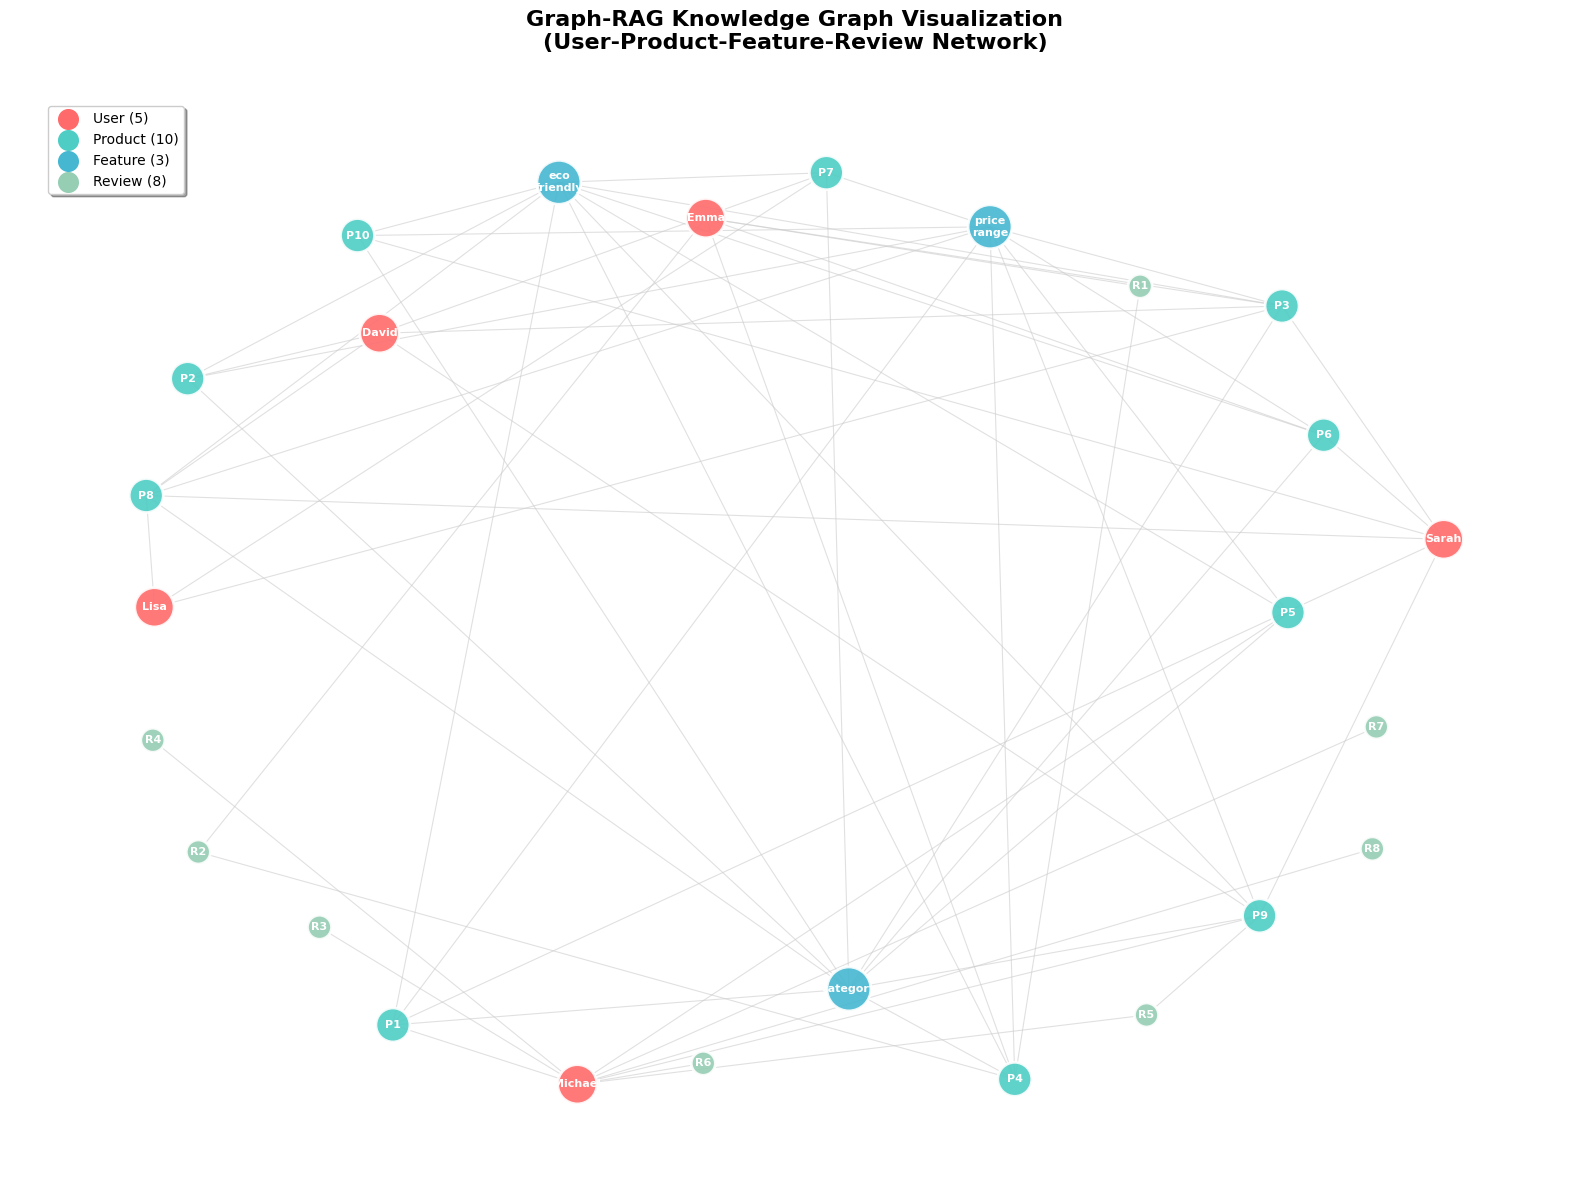


🔍 FOCUSED VIEW: User-Product Connections


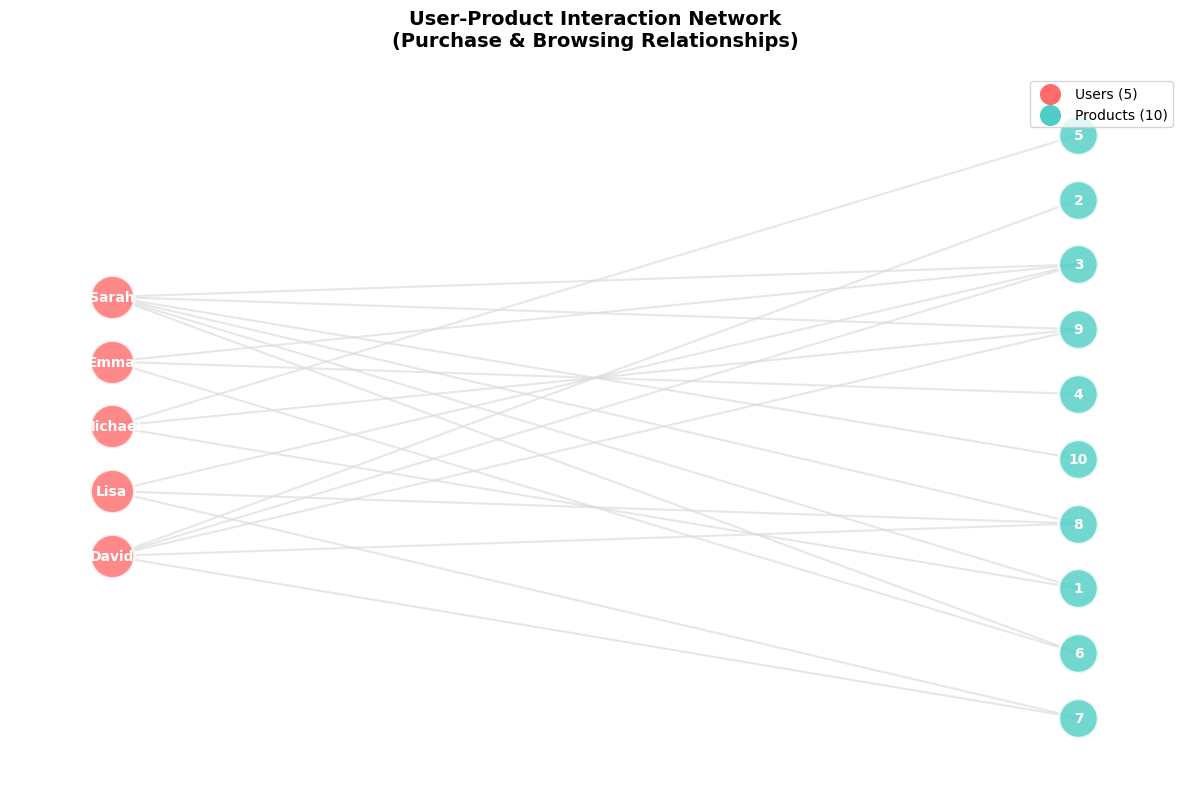


🎉 Graph-RAG Demo Complete!

📈 SUMMARY:
• Full graph: 160 nodes, 775 edges
• Visualization: 26 nodes, 61 edges
• Node types: 4 different types
• Edge types: 5 different relationships
• Graph density: 6.1%
• Average degree: 9.7
• Average path length: 2.70
• Diameter: 4

✨ The graph successfully captures the complex relationships between users, products, features, and reviews in your retail recommendation system!


In [25]:
# System Analysis and Graph Visualization
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict

print("📊 GRAPH ANALYSIS & VISUALIZATION")
print("=" * 60)

# Basic graph statistics
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

# Node distribution analysis
node_types = {}
node_type_colors = {
    'user': '#FF6B6B',      # Red
    'product': '#4ECDC4',   # Teal
    'feature': '#45B7D1',   # Blue
    'review': '#96CEB4'     # Green
}

for node in G.nodes():
    node_type = node.split(':')[0]
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("\nNode distribution:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

# Edge distribution analysis
edge_types = defaultdict(int)
for u, v, data in G.edges(data=True):
    edge_type = data.get('edge_type', 'unknown')
    edge_types[edge_type] += 1

print(f"\nEdge distribution:")
for edge_type, count in edge_types.items():
    print(f"  {edge_type}: {count}")

print("\n" + "=" * 60)
print("🎨 GRAPH VISUALIZATION")
print("=" * 60)

# Create a more manageable subgraph for visualization
# Select a subset of nodes for cleaner visualization
users_subset = list(range(1, 6))  # First 5 users
products_subset = list(range(1, 11))  # First 10 products
features_subset = ['category', 'eco_friendly', 'price_range']  # Key features

# Build subgraph
subgraph_nodes = []

# Add user nodes
for user_id in users_subset:
    subgraph_nodes.append(f"user:{user_id}")

# Add product nodes
for product_id in products_subset:
    subgraph_nodes.append(f"product:{product_id}")

# Add feature nodes
for feature in features_subset:
    subgraph_nodes.append(f"feature:{feature}")

# Add some review nodes (limit to avoid clutter)
review_nodes = [node for node in G.nodes() if node.startswith('review:')][:8]
subgraph_nodes.extend(review_nodes)

# Create subgraph
H = G.subgraph(subgraph_nodes).copy()

print(f"Visualization showing {H.number_of_nodes()} nodes and {H.number_of_edges()} edges")
print("(Subset of full graph for clarity)")

# Set up the visualization
plt.figure(figsize=(16, 12))

# Create layout with better spacing
pos = nx.spring_layout(H, k=3, iterations=50, seed=42)

# Prepare node colors and sizes based on type
node_colors = []
node_sizes = []
node_labels = {}

for node in H.nodes():
    node_type = node.split(':')[0]
    node_colors.append(node_type_colors.get(node_type, '#CCCCCC'))
    
    # Set node sizes based on type
    if node_type == 'user':
        node_sizes.append(800)
        # Use actual user names for labels
        user_id = int(node.split(':')[1])
        user_name = USER_NAMES.get(user_id, f"User {user_id}")
        node_labels[node] = user_name.split()[0]  # First name only
    elif node_type == 'product':
        node_sizes.append(600)
        product_id = node.split(':')[1]
        node_labels[node] = f"P{product_id}"
    elif node_type == 'feature':
        node_sizes.append(1000)
        feature_name = node.split(':')[1]
        node_labels[node] = feature_name.replace('_', '\n')
    elif node_type == 'review':
        node_sizes.append(300)
        review_id = node.split(':')[1]
        node_labels[node] = f"R{review_id}"
    else:
        node_sizes.append(400)
        node_labels[node] = node.split(':')[1]

# Draw the graph
# Draw edges first (background)
nx.draw_networkx_edges(H, pos, 
                      edge_color='#CCCCCC', 
                      alpha=0.6, 
                      width=0.8)

# Draw nodes
nx.draw_networkx_nodes(H, pos, 
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.9,
                      edgecolors='white',
                      linewidths=2)

# Draw labels
nx.draw_networkx_labels(H, pos, 
                       labels=node_labels,
                       font_size=8,
                       font_weight='bold',
                       font_color='white')

# Create a clean layout
plt.title('Graph-RAG Knowledge Graph Visualization\n(User-Product-Feature-Review Network)', 
          fontsize=16, fontweight='bold', pad=20)

# Create legend
legend_elements = []
for node_type, color in node_type_colors.items():
    count = sum(1 for node in H.nodes() if node.startswith(node_type))
    legend_elements.append(plt.scatter([], [], c=color, s=200, 
                                     label=f'{node_type.title()} ({count})'))

plt.legend(handles=legend_elements, 
          loc='upper left', 
          bbox_to_anchor=(0.02, 0.98),
          frameon=True,
          fancybox=True,
          shadow=True)

# Clean up the plot
plt.axis('off')
plt.tight_layout()

# Add a subtle grid for better readability
plt.grid(True, alpha=0.1)

# Show the graph
plt.show()

# Additional smaller focused visualization - User-Product connections only
print("\n" + "=" * 60)
print("🔍 FOCUSED VIEW: User-Product Connections")
print("=" * 60)

# Create a simpler user-product graph
plt.figure(figsize=(12, 8))

# Get user and product nodes only
user_nodes = [node for node in H.nodes() if node.startswith('user:')]
product_nodes = [node for node in H.nodes() if node.startswith('product:')]
simple_nodes = user_nodes + product_nodes

# Create simple subgraph
simple_graph = H.subgraph(simple_nodes).copy()

# Create bipartite layout
user_pos = {}
product_pos = {}

# Position users on the left
for i, user in enumerate(user_nodes):
    user_pos[user] = (-1, i - len(user_nodes)/2)

# Position products on the right
for i, product in enumerate(product_nodes):
    product_pos[product] = (1, i - len(product_nodes)/2)

simple_pos = {**user_pos, **product_pos}

# Draw the simple graph
nx.draw_networkx_edges(simple_graph, simple_pos,
                      edge_color='#DDDDDD',
                      alpha=0.7,
                      width=1.5)

# Draw user nodes
nx.draw_networkx_nodes(simple_graph, simple_pos,
                      nodelist=user_nodes,
                      node_color='#FF6B6B',
                      node_size=1000,
                      alpha=0.8,
                      edgecolors='white',
                      linewidths=2)

# Draw product nodes
nx.draw_networkx_nodes(simple_graph, simple_pos,
                      nodelist=product_nodes,
                      node_color='#4ECDC4',
                      node_size=800,
                      alpha=0.8,
                      edgecolors='white',
                      linewidths=2)

# Add labels
simple_labels = {}
for node in simple_graph.nodes():
    if node.startswith('user:'):
        user_id = int(node.split(':')[1])
        user_name = USER_NAMES.get(user_id, f"User {user_id}")
        simple_labels[node] = user_name.split()[0]
    else:
        simple_labels[node] = node.split(':')[1]

nx.draw_networkx_labels(simple_graph, simple_pos,
                       labels=simple_labels,
                       font_size=10,
                       font_weight='bold',
                       font_color='white')

plt.title('User-Product Interaction Network\n(Purchase & Browsing Relationships)', 
          fontsize=14, fontweight='bold', pad=20)

# Add legend for simple graph
plt.scatter([], [], c='#FF6B6B', s=200, label=f'Users ({len(user_nodes)})')
plt.scatter([], [], c='#4ECDC4', s=200, label=f'Products ({len(product_nodes)})')
plt.legend(loc='upper right')

plt.axis('off')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("🎉 Graph-RAG Demo Complete!")
print("=" * 60)

# Summary statistics
print(f"\n📈 SUMMARY:")
print(f"• Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"• Visualization: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")
print(f"• Node types: {len(node_types)} different types")
print(f"• Edge types: {len(edge_types)} different relationships")
print(f"• Graph density: {nx.density(G):.1%}")
print(f"• Average degree: {sum(dict(G.degree()).values()) / len(G.nodes()):.1f}")

if nx.is_connected(G):
    print(f"• Average path length: {nx.average_shortest_path_length(G):.2f}")
    print(f"• Diameter: {nx.diameter(G)}")

print(f"\n✨ The graph successfully captures the complex relationships between users, products, features, and reviews in your retail recommendation system!")